In [1]:
!pip install keras-tuner==1.0.1
!pip install tensorflow==2.3.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import tensorflow as tf
import kerastuner
import matplotlib.pyplot as plt
import numpy as np

In [3]:
tf.__version__

'2.3.0'

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [5]:
x_train.shape

(60000, 28, 28)

In [6]:
set(y_train)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

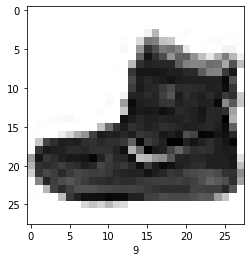

In [7]:
plt.imshow(x_train[0], cmap="binary")
plt.xlabel(y_train[0])
plt.show()

In [8]:
def create_model(hp=None):
  num_hidden_layers = 1
  num_units = 8
  dropout_rate = 0.1
  learning_rate = 0.01

  if hp:
    number_hidden_layers = hp.Choice("num_hidden_layers", values=[1, 2, 3])
    num_units = hp.Choice("num_units", values=[8, 16, 32])
    dropout_rate = hp.Float("dropout_rate", min_value = 0.1, max_value = 0.5)
    learning_rate = hp.Float("learning_rate", min_value=0.0001, max_value=0.01)

  model = tf.keras.models.Sequential()

  model.add(tf.keras.layers.Flatten(input_shape=(28,28)))
  model.add(tf.keras.layers.Lambda(lambda x: x/255.0))

  for _ in range(0, num_hidden_layers):
    model.add(tf.keras.layers.Dense(num_units, activation="relu"))
    model.add(tf.keras.layers.Dropout(dropout_rate))

  model.add(tf.keras.layers.Dense(10, activation="softmax"))

  model.compile(
      loss = "sparse_categorical_crossentropy",
      optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate),
      metrics = ["accuracy"]
  )
  return model


In [9]:
create_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
lambda (Lambda)              (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 8)                 6280      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                90        
Total params: 6,370
Trainable params: 6,370
Non-trainable params: 0
_________________________________________________________________


In [10]:
class CustomTuner(kerastuner.tuners.BayesianOptimization):
  def run_trial(self, trial, *args, **kwargs):
    kwargs["batch_size"] = trial.hyperparameters.Int("batch_size", 32, 128, step =32)
    super(CustomTuner, self).run_trial(trial, *args, **kwargs)
    # return super(CustomTuner, self).run_trial(trial, *args, **kwargs)

In [11]:
tuner = CustomTuner(
    create_model,
    objective = "val_accuracy",
    max_trials = 20,
    directory="logs",
    project_name="fashion_mnist",
    overwrite=True
)

In [12]:
tuner.search_space_summary()

In [13]:
tuner.search(
    x_train, y_train,
    validation_data = (x_test, y_test),
    epochs = 5,
    verbose = False,
)

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


INFO:tensorflow:Oracle triggered exit


In [14]:
tuner.results_summary(1)

In [15]:
model = tuner.get_best_models(num_models=1)[0]
# model.summary()

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
lambda (Lambda)              (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


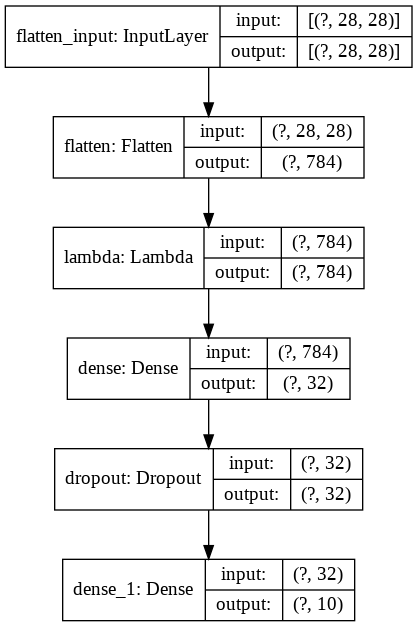

In [19]:
tf.keras.utils.plot_model(model, show_shapes=True,
    show_layer_names=True)

In [20]:
print([layer.name for layer in model.layers])


['flatten', 'lambda', 'dense', 'dropout', 'dense_1']


In [21]:
print(model.get_layer("flatten").output.shape)
print(model.get_layer("flatten").output.dtype)

(None, 784)
<dtype: 'float32'>


In [22]:
print(x_train[0].dtype)

uint8


In [23]:
_ = model.fit(
   x_train,
   y_train,
   validation_data = (x_test, y_test),
   epochs = 20, batch_size = 128,
   callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3)] 
)

Epoch 1/20
469/469 [==============================] - 1s 3ms/step - loss: 0.4307 - accuracy: 0.8460 - val_loss: 0.4081 - val_accuracy: 0.8519
Epoch 2/20
469/469 [==============================] - 1s 3ms/step - loss: 0.4227 - accuracy: 0.8475 - val_loss: 0.3936 - val_accuracy: 0.8605
Epoch 3/20
469/469 [==============================] - 1s 3ms/step - loss: 0.4168 - accuracy: 0.8482 - val_loss: 0.3877 - val_accuracy: 0.8576
Epoch 4/20
469/469 [==============================] - 1s 3ms/step - loss: 0.4115 - accuracy: 0.8506 - val_loss: 0.3894 - val_accuracy: 0.8574
Epoch 5/20
469/469 [==============================] - 1s 3ms/step - loss: 0.4078 - accuracy: 0.8515 - val_loss: 0.4012 - val_accuracy: 0.8543
